In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_MaleUrine_Exposure'
subjects = ace.list_subjects(root_directory)
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'

In [3]:
# Take the SW > 19
subjects = [sub for sub in subjects if sub[0:2]=='SW' and int(sub[2:].split('_')[0]) in set(range(19,36))]

In [4]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [5]:
def load_subject(subject):
    df_mouse = pd.read_csv(data_directory + subject + '/cells150_10-10.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

# Analysis on SWISS 19-35 with father : threshold 300

In [7]:
# NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results/dict_results_across_mice_SW19-35-150_10-10.npy', dict_results_across_mice)

In [8]:
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_SW19-35-150_10-10.npy', allow_pickle=True).item()

In [9]:
# removed key corresponding to SW21_Fam
dict_results_across_mice.pop('SW21_Fam')
subjects.remove('SW21_Fam')

# List areas with null cell count

In [10]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

# List areas with no volume

In [11]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [12]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['SW25_Control',
  'SW19_Control',
  'SW24_Control',
  'SW31_Control',
  'SW30_Control'],
 'Unfam': ['SW26_Unfam',
  'SW20_Unfam',
  'SW22_Unfam',
  'SW28_Unfam',
  'SW34_Unfam',
  'SW32_Unfam'],
 'Fam': ['SW27_Fam', 'SW23_Fam', 'SW29_Fam', 'SW33_Fam', 'SW35_Fam']}

# Calculate cell count across experimental groups

In [13]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

## Calculate t-tests across groups per area

In [14]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,NaN,0.186447,0.186447
1,Primary motor area,0.507432,0.988302,0.301957
2,Secondary motor area,0.787151,0.846485,0.71964
3,Primary somatosensory area,0.345585,0.514431,0.518788
4,Supplemental somatosensory area,0.331234,0.960407,0.384984
...,...,...,...,...
293,Flocculus,0.38876,0.528103,0.136313
294,Fastigial nucleus,0.18604,0.11822,0.489175
295,Interposed nucleus,0.122664,0.0310057,0.722871
296,Dentate nucleus,NaN,NaN,NaN


In [15]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [16]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Magnocellular nucleus,0.00203254
Medial preoptic area,0.00229622
Anterior amygdalar area,0.0072666
Medial amygdalar nucleus,0.0077529
Nucleus incertus,0.0104169
Fundus of striatum,0.0177477
Nucleus of the lateral olfactory tract,0.0207437
Suprageniculate nucleus,0.0252289
Bed nucleus of the accessory olfactory tract,0.0255562


In [17]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Anterior amygdalar area,0.000129565
Nucleus of the lateral olfactory tract,0.000257982
Fundus of striatum,0.000869188
Medial preoptic nucleus,0.00429997
Medial preoptic area,0.00787347
Magnocellular nucleus,0.0123352
Central amygdalar nucleus,0.0140686
Lateral vestibular nucleus,0.0166801
Lingula (I),0.0177453


In [18]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Peripeduncular nucleus,0.0138111
Globus pallidus internal segment,0.0187685
Posterior limiting nucleus of the thalamus,0.0338848
Nucleus sagulum,0.0370441
Paraventricular nucleus of the thalamus,0.0397419
Supragenual nucleus,0.0424081
Midbrain reticular nucleus retrorubral area,0.0448662
Subparafascicular nucleus,0.064149
Parabrachial nucleus,0.0641859


## Mann Whitney Test for comparison across groups

In [19]:
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,NaN,0.110336,0.110336
1,Primary motor area,0.5,0.427403,0.157651
2,Secondary motor area,0.417266,0.463632,0.324038
3,Primary somatosensory area,0.148135,0.392096,0.392096
4,Supplemental somatosensory area,0.201698,0.463632,0.324038
...,...,...,...,...
293,Flocculus,0.297365,0.260458,0.0975202
294,Fastigial nucleus,0.376649,0.0414187,0.261408
295,Interposed nucleus,0.148135,0.0603454,0.324038
296,Dentate nucleus,NaN,NaN,NaN


In [20]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [21]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Magnocellular nucleus,0.00583366
Medial preoptic area,0.00596262
Medial preoptic nucleus,0.00609289
Anterior amygdalar area,0.00609289
Medial amygdalar nucleus,0.0107859
Fundus of striatum,0.0107859
Suprageniculate nucleus,0.0124042
Substantia nigra compact part,0.0175075
Nucleus incertus,0.0180726


In [22]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Lingula (I),0.00363538
Abducens nucleus,0.00370392
Nucleus of the lateral olfactory tract,0.00398471
Medial preoptic area,0.00398471
Anterior amygdalar area,0.00405656
Fundus of striatum,0.00405656
Dorsal tegmental nucleus,0.00592183
Magnocellular nucleus,0.00664259
Nucleus incertus,0.00674862


In [23]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:35].set_index('area')

,pval_Fam_vs_Unfam
area,
Nucleus sagulum,0.00428513
Peripeduncular nucleus,0.00814874
Dorsal tegmental nucleus,0.0156143
Lingula (I),0.0172548
Nucleus y,0.021951
Posterior limiting nucleus of the thalamus,0.0243304
Midbrain reticular nucleus retrorubral area,0.026239
Paraventricular nucleus of the thalamus,0.0273406
Supragenual nucleus,0.0292883


## Calculate cross corr across groups per area on cell count

In [24]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

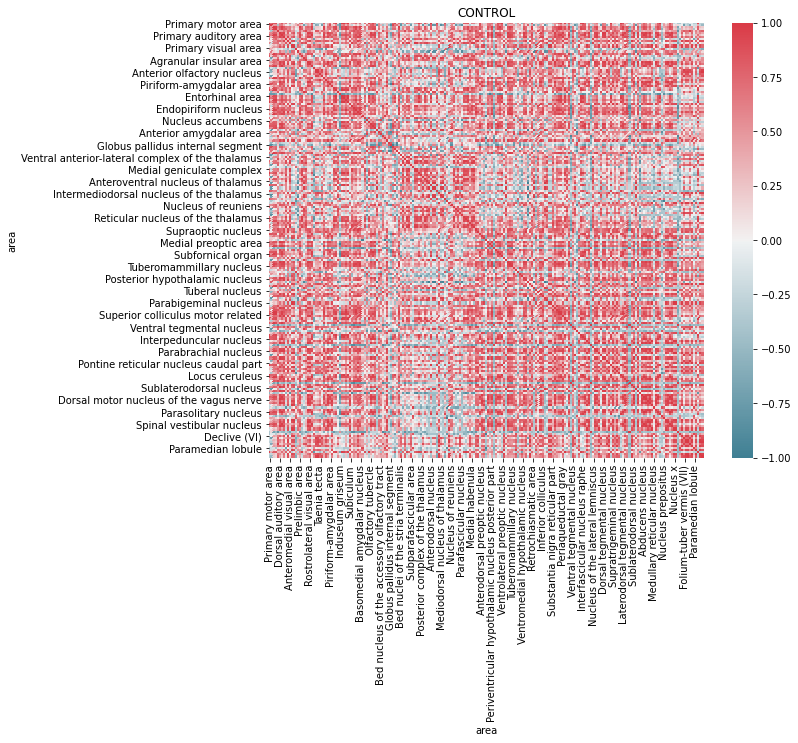

In [25]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

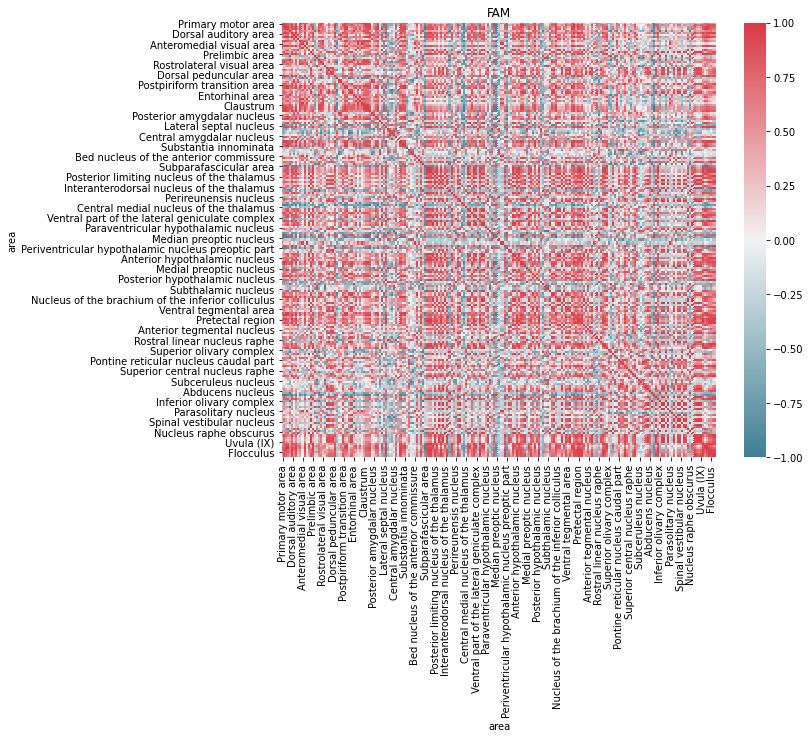

In [26]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

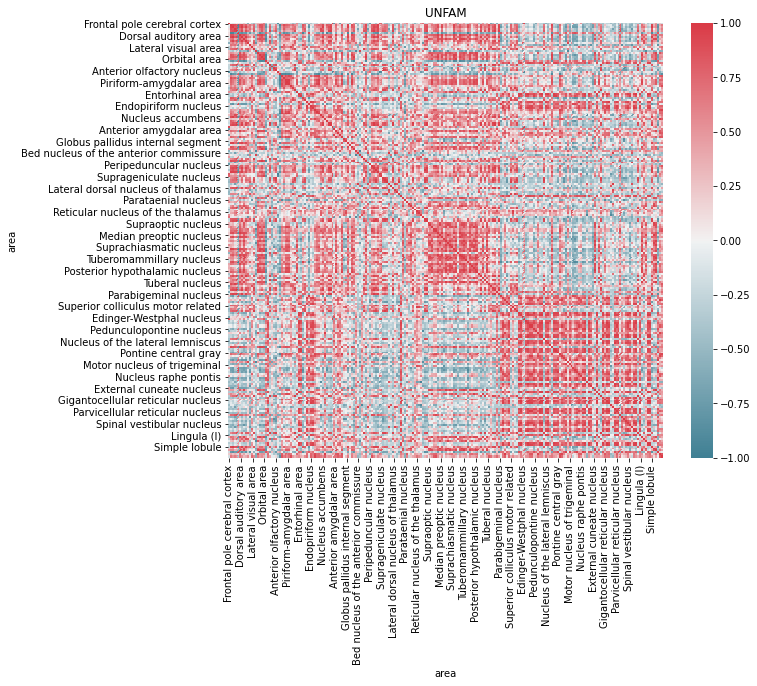

In [27]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [28]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

## T-test on energy across groups

In [29]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)

In [30]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [31]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Nucleus incertus,0.00534011
Magnocellular nucleus,0.0088181
Medial amygdalar nucleus,0.0088761
Medial preoptic area,0.00906874
Anterior amygdalar area,0.0147614
Suprageniculate nucleus,0.0223114
Nucleus of the lateral olfactory tract,0.0229049
Bed nucleus of the accessory olfactory tract,0.0246752
Fundus of striatum,0.0256226


In [32]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Anterior amygdalar area,0.00025374
Nucleus of the lateral olfactory tract,0.000983312
Fundus of striatum,0.00177272
Medial preoptic nucleus,0.00316861
Medial preoptic area,0.00937692
Bed nuclei of the stria terminalis,0.0132513
Lateral vestibular nucleus,0.0191017
Magnocellular nucleus,0.0214435
Nucleus incertus,0.0230878


In [33]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Interfascicular nucleus raphe,0.0136303
Posterior limiting nucleus of the thalamus,0.0255439
Globus pallidus internal segment,0.0299824
Paraventricular nucleus of the thalamus,0.0427313
Supragenual nucleus,0.0445247
Midbrain reticular nucleus retrorubral area,0.053272
Peripeduncular nucleus,0.0567293
Parabrachial nucleus,0.062273
Nucleus sagulum,0.0826939


## Mann-Whitney Test across groups

In [34]:
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')

In [35]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [36]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:40].set_index('area')

,pval_Control_vs_Fam
area,
Accessory abducens nucleus,0.00609289
Medial preoptic nucleus,0.00609289
Lobule IV,0.00609289
Suprachiasmatic preoptic nucleus,0.00609289
Medial preoptic area,0.00609289
Anterior hypothalamic area,0.00609289
Lateral strip of striatum,0.00609289
Nucleus intercalatus,0.00609289
Nucleus circularis,0.00609289


In [37]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:50].set_index('area')

,pval_Control_vs_Unfam
area,
Dorsal tegmental nucleus,0.00370392
Abducens nucleus,0.00377312
Lingula (I),0.00377312
Cochlear nucleus subpedunclular granular region,0.00405656
Efferent cochlear group,0.00405656
Efferent vestibular nucleus,0.00405656
Accessory abducens nucleus,0.00405656
Nucleus z,0.00405656
Medial preoptic area,0.00405656


In [38]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Control_vs_Fam']][0:50].set_index('area')

,pval_Control_vs_Fam
area,
Nucleus sagulum,0.220343
Granular lamina of the cochlear nuclei,0.00609289
Nucleus z,0.00609289
Accessory abducens nucleus,0.00609289
Efferent vestibular nucleus,0.00609289
Efferent cochlear group,0.00609289
Intercollicular nucleus,0.00609289
Suprachiasmatic preoptic nucleus,0.00609289
Nucleus intercalatus,0.00609289


## Calculate cross corr matrix across experimental groups on energy

In [39]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

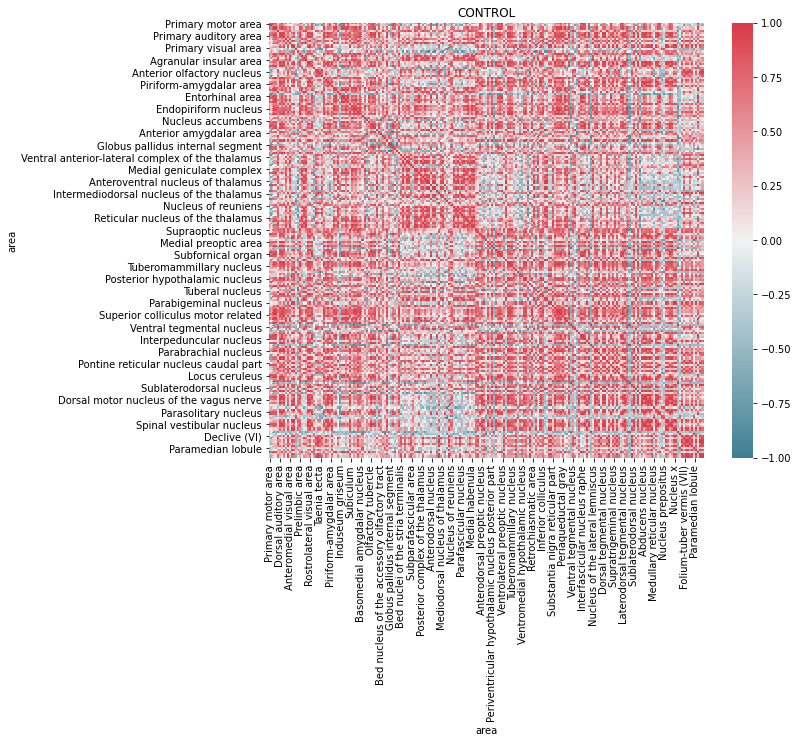

In [40]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

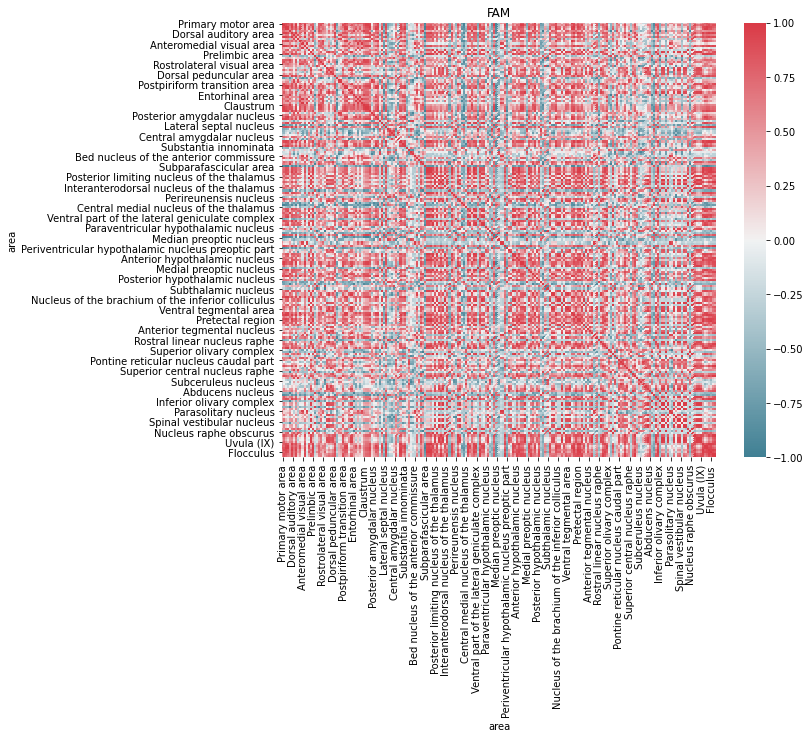

In [41]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

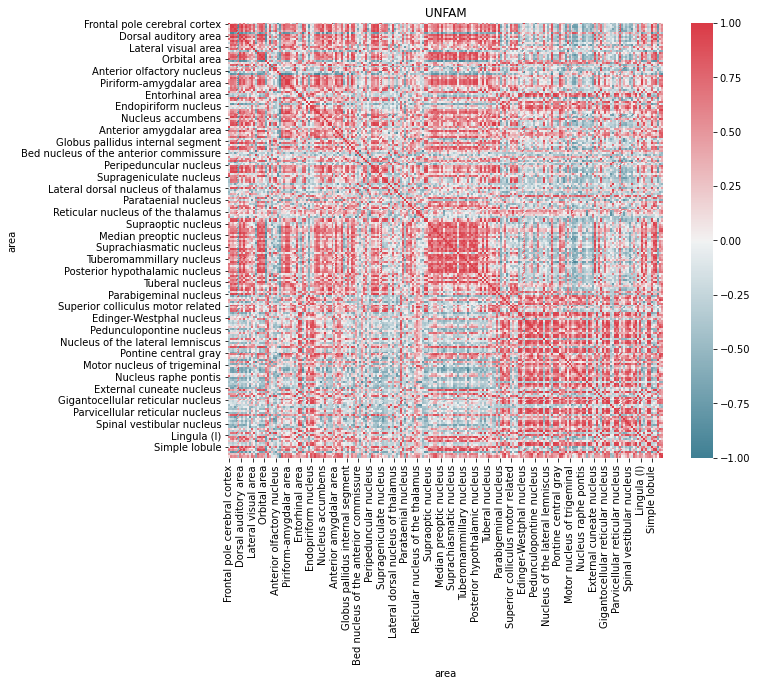

In [42]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')